# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import os
import gc


import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split, Dataset

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Data Preparation

In [ ]:
# Resize Data Python Script
from PIL import Image
import os, sys
import glob

path = "/Users/scottysingh/Downloads/birds/test/0"
newpath = "/Users/scottysingh/Desktop/birds-224/test/"
dirs = os.listdir( path )

IMAGE_SIZE = 224

def resize():
    for filename in glob.iglob(path + '**/*.jpg', recursive=True):
        im = Image.open(filename)
        f, e = os.path.splitext(filename)
        dirname = os.path.basename(os.path.dirname(filename))
        basename = os.path.basename(filename)
        print(filename)
        imResize = im.resize((IMAGE_SIZE,IMAGE_SIZE), Image.ANTIALIAS)
        new_dir = newpath + dirname + '/'
        if not os.path.exists(new_dir):
            os.makedirs(new_dir)
        if imResize.mode in ("RGBA", "P"):
            imResize = imResize.convert("RGB")
        try:
            imResize.save(newpath + dirname + '/' + basename, 'JPEG')
        except e:
            print(e)
        

resize()

In [4]:
def get_bird_data(augmentation=0):

    # Define transformations for train and test set
    transform_train = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224, padding=8, padding_mode='edge'), # Take 224x224 crops from padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
    ])

    # Generate train, val, and test datasets
    trainset = torchvision.datasets.ImageFolder(root='../input/birds23wi/birds/train', transform=transform_train)
    testset = torchvision.datasets.ImageFolder(root='../input/birds23wi/birds/test', transform=transform_test)

    # 90:10 split of training set to generate a validation set
    train_split, val_split = random_split(trainset, [int(0.9 * len(trainset) + 1), int( 0.1 * len(trainset))])

    trainloader = torch.utils.data.DataLoader(train_split, batch_size=128, shuffle=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(val_split, batch_size=1, shuffle=False, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)

    classes = open("../input/birds23wi/birds/names.txt").read().strip().split("\n")
    class_to_idx = trainset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'val': valloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()

Tundra Swan


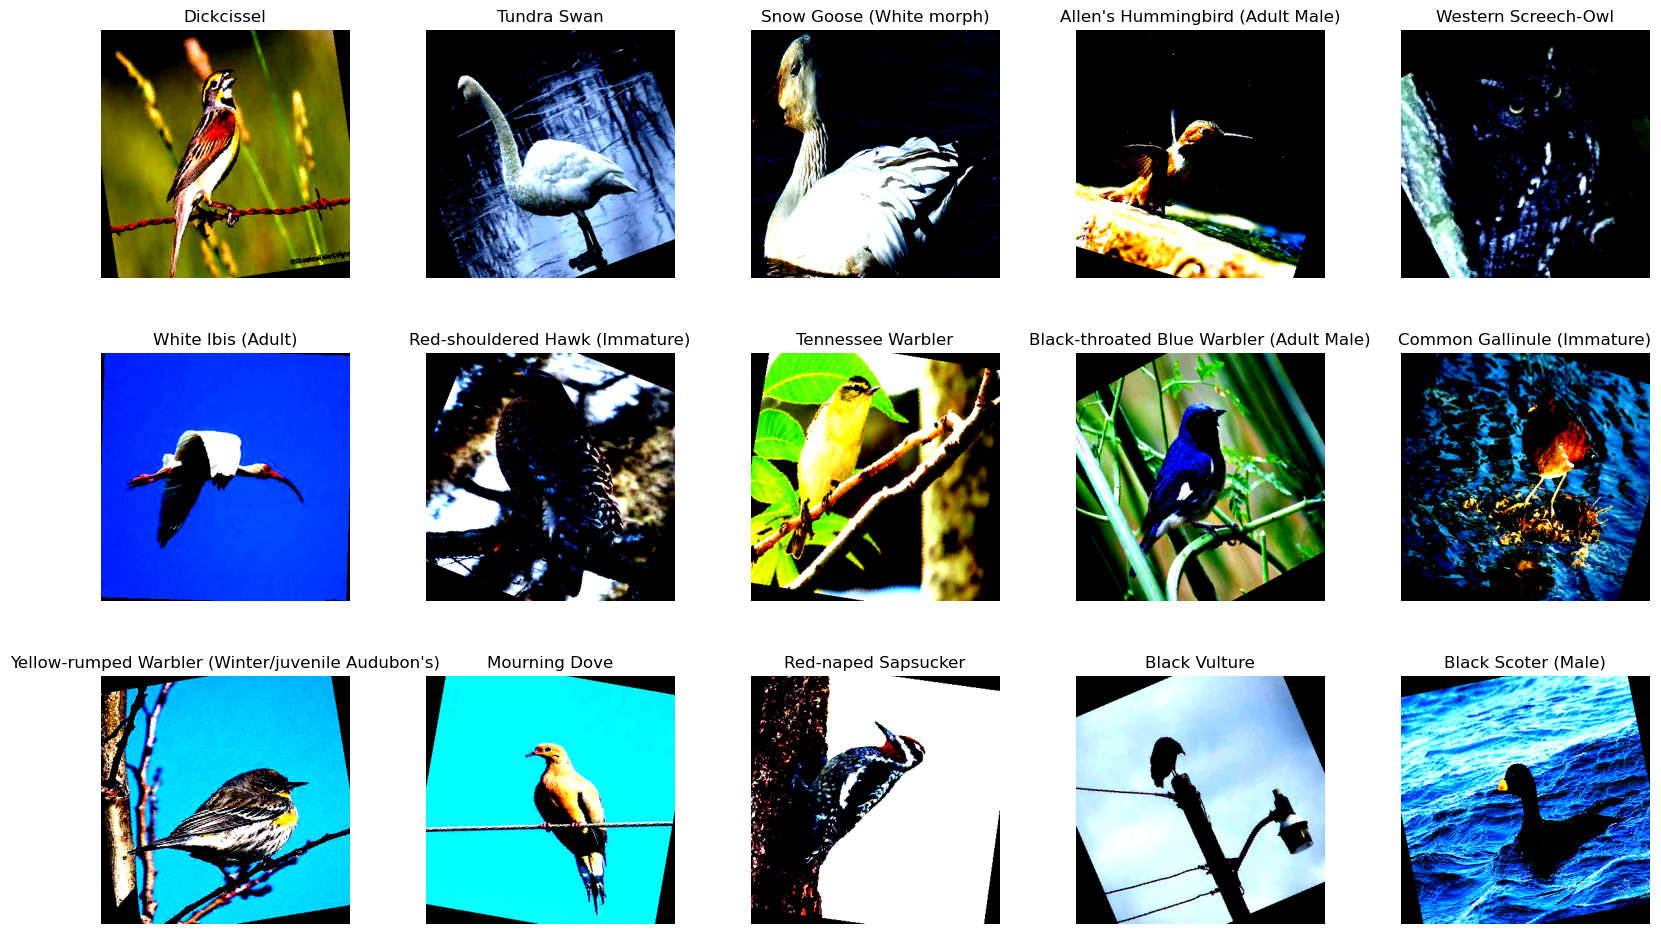

In [48]:
dataiter = iter(data['train'])
images, labels = next(dataiter)
images = images[:15]
labels = labels[:15]

plt.figure(figsize = (20 , 20))

for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    npimg = images[i].numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f'{data["to_name"][labels[i].item()]}')
    plt.axis("off")

# Helper Methods (Train, Predict, Accuracy)

In [20]:
def train(net, dataloader, valloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    losses = []
    val_losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0
        net.train()
        
        gc.collect()
        torch.cuda.empty_cache()

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0

        # Validation loop; use .no_grad() context manager to save memory.
        net.eval()
        val_loss = 0.0

        with torch.no_grad():
          for batch in valloader:
            inputs, labels = batch[0].to(device), batch[1].to(device)
            ouputs = net(inputs)
            loss = criterion(ouputs, labels)

            val_losses.append(loss.item())
            
          gc.collect()
          torch.cuda.empty_cache()

        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
            
        gc.collect()
        torch.cuda.empty_cache()

    return losses, val_losses

In [42]:
def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data['to_class'][predicted.item()]))
    out.close()

In [33]:
def accuracy(net, dataloader):
  net.to(device)
  net.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

In [33]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

# Transfer Learning

In [17]:
torch.hub.list('pytorch/vision:v0.6.0')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


['alexnet',
 'deeplabv3_resnet101',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'fcn_resnet101',
 'googlenet',
 'inception_v3',
 'mobilenet_v2',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'squeezenet1_0',
 'squeezenet1_1',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn',
 'wide_resnet101_2',
 'wide_resnet50_2']

## Resnet18

In [31]:
resnet18 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet18.fc = nn.Linear(512, 555) # This will reinitialize the layer as well

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [37]:
losses, val_losses = train(resnet18, data['train'], data['val'], epochs=3, lr=0.001, print_every=10)

[0,    10] loss: 1.488
[0,    20] loss: 1.543
[0,    30] loss: 1.554
[0,    40] loss: 1.500
[0,    50] loss: 1.467
[0,    60] loss: 1.557
[0,    70] loss: 1.475
[0,    80] loss: 1.515
[0,    90] loss: 1.442
[0,   100] loss: 1.525
[0,   110] loss: 1.454
[0,   120] loss: 1.556
[0,   130] loss: 1.513
[0,   140] loss: 1.510
[0,   150] loss: 1.510
[0,   160] loss: 1.372
[0,   170] loss: 1.468
[0,   180] loss: 1.540
[0,   190] loss: 1.500
[0,   200] loss: 1.483
[0,   210] loss: 1.498
[0,   220] loss: 1.445
[0,   230] loss: 1.523
[0,   240] loss: 1.422
[0,   250] loss: 1.504
[0,   260] loss: 1.464
[0,   270] loss: 1.506
[1,    10] loss: 1.499
[1,    20] loss: 1.417
[1,    30] loss: 1.433
[1,    40] loss: 1.491
[1,    50] loss: 1.370
[1,    60] loss: 1.404
[1,    70] loss: 1.464
[1,    80] loss: 1.424
[1,    90] loss: 1.394
[1,   100] loss: 1.438
[1,   110] loss: 1.429
[1,   120] loss: 1.435
[1,   130] loss: 1.452
[1,   140] loss: 1.482
[1,   150] loss: 1.458
[1,   160] loss: 1.481
[1,   170] 

In [55]:
def get_bird_data(augmentation=0):

    # Define transformations for train and test set
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),   # 50% of time flip image along y-axis
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
    ])

    # Generate train, val, and test datasets
    trainset = torchvision.datasets.ImageFolder(root='../input/birds224/birds-224/train', transform=transform_train)
    testset = torchvision.datasets.ImageFolder(root='../input/birds224/birds-224/test', transform=transform_test)

    # 90:10 split of training set to generate a validation set
    train_split, val_split = random_split(trainset, [int(0.9 * len(trainset) + 1), int( 0.1 * len(trainset))])

    trainloader = torch.utils.data.DataLoader(train_split, batch_size=32, shuffle=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(val_split, batch_size=1, shuffle=False, num_workers=4)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)

    classes = open("../input/birds23wi/birds/names.txt").read().strip().split("\n")
    class_to_idx = trainset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'val': valloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([4, 3, 224, 224])


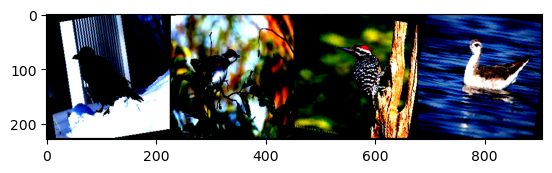

In [26]:
dataiter = iter(data['train'])
images, labels = next(dataiter)
images = images[:4]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))

## Resnet50

In [45]:
resnet50 = torchvision.models.resnet50(weights="IMAGENET1K_V2")
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 555)
resnet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [48]:
print(resnet50.children())
for param in resnet50.features[0:4].parameters():
      param.requires_grad = False

<generator object Module.children at 0x7fd43f1ca150>


AttributeError: 'ResNet' object has no attribute 'features'

In [16]:
checkpoints = '/kaggle/working/Resnet50/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

In [29]:
checkpoints = '/kaggle/working/Resnet50/'
state = torch.load(checkpoints + 'checkpoint-1.pkl')
print(state['epoch'])

1


In [56]:
train_losses, val_losses = train(model, data['train'], data['val'], epochs=2, lr=0.01, print_every=10, checkpoint_path=checkpoints, state=state)

RuntimeError: Error(s) in loading state_dict for EfficientNet:
	Missing key(s) in state_dict: "features.0.0.weight", "features.0.1.weight", "features.0.1.bias", "features.0.1.running_mean", "features.0.1.running_var", "features.1.0.block.0.0.weight", "features.1.0.block.0.1.weight", "features.1.0.block.0.1.bias", "features.1.0.block.0.1.running_mean", "features.1.0.block.0.1.running_var", "features.1.1.block.0.0.weight", "features.1.1.block.0.1.weight", "features.1.1.block.0.1.bias", "features.1.1.block.0.1.running_mean", "features.1.1.block.0.1.running_var", "features.2.0.block.0.0.weight", "features.2.0.block.0.1.weight", "features.2.0.block.0.1.bias", "features.2.0.block.0.1.running_mean", "features.2.0.block.0.1.running_var", "features.2.0.block.1.0.weight", "features.2.0.block.1.1.weight", "features.2.0.block.1.1.bias", "features.2.0.block.1.1.running_mean", "features.2.0.block.1.1.running_var", "features.2.1.block.0.0.weight", "features.2.1.block.0.1.weight", "features.2.1.block.0.1.bias", "features.2.1.block.0.1.running_mean", "features.2.1.block.0.1.running_var", "features.2.1.block.1.0.weight", "features.2.1.block.1.1.weight", "features.2.1.block.1.1.bias", "features.2.1.block.1.1.running_mean", "features.2.1.block.1.1.running_var", "features.2.2.block.0.0.weight", "features.2.2.block.0.1.weight", "features.2.2.block.0.1.bias", "features.2.2.block.0.1.running_mean", "features.2.2.block.0.1.running_var", "features.2.2.block.1.0.weight", "features.2.2.block.1.1.weight", "features.2.2.block.1.1.bias", "features.2.2.block.1.1.running_mean", "features.2.2.block.1.1.running_var", "features.2.3.block.0.0.weight", "features.2.3.block.0.1.weight", "features.2.3.block.0.1.bias", "features.2.3.block.0.1.running_mean", "features.2.3.block.0.1.running_var", "features.2.3.block.1.0.weight", "features.2.3.block.1.1.weight", "features.2.3.block.1.1.bias", "features.2.3.block.1.1.running_mean", "features.2.3.block.1.1.running_var", "features.3.0.block.0.0.weight", "features.3.0.block.0.1.weight", "features.3.0.block.0.1.bias", "features.3.0.block.0.1.running_mean", "features.3.0.block.0.1.running_var", "features.3.0.block.1.0.weight", "features.3.0.block.1.1.weight", "features.3.0.block.1.1.bias", "features.3.0.block.1.1.running_mean", "features.3.0.block.1.1.running_var", "features.3.1.block.0.0.weight", "features.3.1.block.0.1.weight", "features.3.1.block.0.1.bias", "features.3.1.block.0.1.running_mean", "features.3.1.block.0.1.running_var", "features.3.1.block.1.0.weight", "features.3.1.block.1.1.weight", "features.3.1.block.1.1.bias", "features.3.1.block.1.1.running_mean", "features.3.1.block.1.1.running_var", "features.3.2.block.0.0.weight", "features.3.2.block.0.1.weight", "features.3.2.block.0.1.bias", "features.3.2.block.0.1.running_mean", "features.3.2.block.0.1.running_var", "features.3.2.block.1.0.weight", "features.3.2.block.1.1.weight", "features.3.2.block.1.1.bias", "features.3.2.block.1.1.running_mean", "features.3.2.block.1.1.running_var", "features.3.3.block.0.0.weight", "features.3.3.block.0.1.weight", "features.3.3.block.0.1.bias", "features.3.3.block.0.1.running_mean", "features.3.3.block.0.1.running_var", "features.3.3.block.1.0.weight", "features.3.3.block.1.1.weight", "features.3.3.block.1.1.bias", "features.3.3.block.1.1.running_mean", "features.3.3.block.1.1.running_var", "features.4.0.block.0.0.weight", "features.4.0.block.0.1.weight", "features.4.0.block.0.1.bias", "features.4.0.block.0.1.running_mean", "features.4.0.block.0.1.running_var", "features.4.0.block.1.0.weight", "features.4.0.block.1.1.weight", "features.4.0.block.1.1.bias", "features.4.0.block.1.1.running_mean", "features.4.0.block.1.1.running_var", "features.4.0.block.2.fc1.weight", "features.4.0.block.2.fc1.bias", "features.4.0.block.2.fc2.weight", "features.4.0.block.2.fc2.bias", "features.4.0.block.3.0.weight", "features.4.0.block.3.1.weight", "features.4.0.block.3.1.bias", "features.4.0.block.3.1.running_mean", "features.4.0.block.3.1.running_var", "features.4.1.block.0.0.weight", "features.4.1.block.0.1.weight", "features.4.1.block.0.1.bias", "features.4.1.block.0.1.running_mean", "features.4.1.block.0.1.running_var", "features.4.1.block.1.0.weight", "features.4.1.block.1.1.weight", "features.4.1.block.1.1.bias", "features.4.1.block.1.1.running_mean", "features.4.1.block.1.1.running_var", "features.4.1.block.2.fc1.weight", "features.4.1.block.2.fc1.bias", "features.4.1.block.2.fc2.weight", "features.4.1.block.2.fc2.bias", "features.4.1.block.3.0.weight", "features.4.1.block.3.1.weight", "features.4.1.block.3.1.bias", "features.4.1.block.3.1.running_mean", "features.4.1.block.3.1.running_var", "features.4.2.block.0.0.weight", "features.4.2.block.0.1.weight", "features.4.2.block.0.1.bias", "features.4.2.block.0.1.running_mean", "features.4.2.block.0.1.running_var", "features.4.2.block.1.0.weight", "features.4.2.block.1.1.weight", "features.4.2.block.1.1.bias", "features.4.2.block.1.1.running_mean", "features.4.2.block.1.1.running_var", "features.4.2.block.2.fc1.weight", "features.4.2.block.2.fc1.bias", "features.4.2.block.2.fc2.weight", "features.4.2.block.2.fc2.bias", "features.4.2.block.3.0.weight", "features.4.2.block.3.1.weight", "features.4.2.block.3.1.bias", "features.4.2.block.3.1.running_mean", "features.4.2.block.3.1.running_var", "features.4.3.block.0.0.weight", "features.4.3.block.0.1.weight", "features.4.3.block.0.1.bias", "features.4.3.block.0.1.running_mean", "features.4.3.block.0.1.running_var", "features.4.3.block.1.0.weight", "features.4.3.block.1.1.weight", "features.4.3.block.1.1.bias", "features.4.3.block.1.1.running_mean", "features.4.3.block.1.1.running_var", "features.4.3.block.2.fc1.weight", "features.4.3.block.2.fc1.bias", "features.4.3.block.2.fc2.weight", "features.4.3.block.2.fc2.bias", "features.4.3.block.3.0.weight", "features.4.3.block.3.1.weight", "features.4.3.block.3.1.bias", "features.4.3.block.3.1.running_mean", "features.4.3.block.3.1.running_var", "features.4.4.block.0.0.weight", "features.4.4.block.0.1.weight", "features.4.4.block.0.1.bias", "features.4.4.block.0.1.running_mean", "features.4.4.block.0.1.running_var", "features.4.4.block.1.0.weight", "features.4.4.block.1.1.weight", "features.4.4.block.1.1.bias", "features.4.4.block.1.1.running_mean", "features.4.4.block.1.1.running_var", "features.4.4.block.2.fc1.weight", "features.4.4.block.2.fc1.bias", "features.4.4.block.2.fc2.weight", "features.4.4.block.2.fc2.bias", "features.4.4.block.3.0.weight", "features.4.4.block.3.1.weight", "features.4.4.block.3.1.bias", "features.4.4.block.3.1.running_mean", "features.4.4.block.3.1.running_var", "features.4.5.block.0.0.weight", "features.4.5.block.0.1.weight", "features.4.5.block.0.1.bias", "features.4.5.block.0.1.running_mean", "features.4.5.block.0.1.running_var", "features.4.5.block.1.0.weight", "features.4.5.block.1.1.weight", "features.4.5.block.1.1.bias", "features.4.5.block.1.1.running_mean", "features.4.5.block.1.1.running_var", "features.4.5.block.2.fc1.weight", "features.4.5.block.2.fc1.bias", "features.4.5.block.2.fc2.weight", "features.4.5.block.2.fc2.bias", "features.4.5.block.3.0.weight", "features.4.5.block.3.1.weight", "features.4.5.block.3.1.bias", "features.4.5.block.3.1.running_mean", "features.4.5.block.3.1.running_var", "features.5.0.block.0.0.weight", "features.5.0.block.0.1.weight", "features.5.0.block.0.1.bias", "features.5.0.block.0.1.running_mean", "features.5.0.block.0.1.running_var", "features.5.0.block.1.0.weight", "features.5.0.block.1.1.weight", "features.5.0.block.1.1.bias", "features.5.0.block.1.1.running_mean", "features.5.0.block.1.1.running_var", "features.5.0.block.2.fc1.weight", "features.5.0.block.2.fc1.bias", "features.5.0.block.2.fc2.weight", "features.5.0.block.2.fc2.bias", "features.5.0.block.3.0.weight", "features.5.0.block.3.1.weight", "features.5.0.block.3.1.bias", "features.5.0.block.3.1.running_mean", "features.5.0.block.3.1.running_var", "features.5.1.block.0.0.weight", "features.5.1.block.0.1.weight", "features.5.1.block.0.1.bias", "features.5.1.block.0.1.running_mean", "features.5.1.block.0.1.running_var", "features.5.1.block.1.0.weight", "features.5.1.block.1.1.weight", "features.5.1.block.1.1.bias", "features.5.1.block.1.1.running_mean", "features.5.1.block.1.1.running_var", "features.5.1.block.2.fc1.weight", "features.5.1.block.2.fc1.bias", "features.5.1.block.2.fc2.weight", "features.5.1.block.2.fc2.bias", "features.5.1.block.3.0.weight", "features.5.1.block.3.1.weight", "features.5.1.block.3.1.bias", "features.5.1.block.3.1.running_mean", "features.5.1.block.3.1.running_var", "features.5.2.block.0.0.weight", "features.5.2.block.0.1.weight", "features.5.2.block.0.1.bias", "features.5.2.block.0.1.running_mean", "features.5.2.block.0.1.running_var", "features.5.2.block.1.0.weight", "features.5.2.block.1.1.weight", "features.5.2.block.1.1.bias", "features.5.2.block.1.1.running_mean", "features.5.2.block.1.1.running_var", "features.5.2.block.2.fc1.weight", "features.5.2.block.2.fc1.bias", "features.5.2.block.2.fc2.weight", "features.5.2.block.2.fc2.bias", "features.5.2.block.3.0.weight", "features.5.2.block.3.1.weight", "features.5.2.block.3.1.bias", "features.5.2.block.3.1.running_mean", "features.5.2.block.3.1.running_var", "features.5.3.block.0.0.weight", "features.5.3.block.0.1.weight", "features.5.3.block.0.1.bias", "features.5.3.block.0.1.running_mean", "features.5.3.block.0.1.running_var", "features.5.3.block.1.0.weight", "features.5.3.block.1.1.weight", "features.5.3.block.1.1.bias", "features.5.3.block.1.1.running_mean", "features.5.3.block.1.1.running_var", "features.5.3.block.2.fc1.weight", "features.5.3.block.2.fc1.bias", "features.5.3.block.2.fc2.weight", "features.5.3.block.2.fc2.bias", "features.5.3.block.3.0.weight", "features.5.3.block.3.1.weight", "features.5.3.block.3.1.bias", "features.5.3.block.3.1.running_mean", "features.5.3.block.3.1.running_var", "features.5.4.block.0.0.weight", "features.5.4.block.0.1.weight", "features.5.4.block.0.1.bias", "features.5.4.block.0.1.running_mean", "features.5.4.block.0.1.running_var", "features.5.4.block.1.0.weight", "features.5.4.block.1.1.weight", "features.5.4.block.1.1.bias", "features.5.4.block.1.1.running_mean", "features.5.4.block.1.1.running_var", "features.5.4.block.2.fc1.weight", "features.5.4.block.2.fc1.bias", "features.5.4.block.2.fc2.weight", "features.5.4.block.2.fc2.bias", "features.5.4.block.3.0.weight", "features.5.4.block.3.1.weight", "features.5.4.block.3.1.bias", "features.5.4.block.3.1.running_mean", "features.5.4.block.3.1.running_var", "features.5.5.block.0.0.weight", "features.5.5.block.0.1.weight", "features.5.5.block.0.1.bias", "features.5.5.block.0.1.running_mean", "features.5.5.block.0.1.running_var", "features.5.5.block.1.0.weight", "features.5.5.block.1.1.weight", "features.5.5.block.1.1.bias", "features.5.5.block.1.1.running_mean", "features.5.5.block.1.1.running_var", "features.5.5.block.2.fc1.weight", "features.5.5.block.2.fc1.bias", "features.5.5.block.2.fc2.weight", "features.5.5.block.2.fc2.bias", "features.5.5.block.3.0.weight", "features.5.5.block.3.1.weight", "features.5.5.block.3.1.bias", "features.5.5.block.3.1.running_mean", "features.5.5.block.3.1.running_var", "features.5.6.block.0.0.weight", "features.5.6.block.0.1.weight", "features.5.6.block.0.1.bias", "features.5.6.block.0.1.running_mean", "features.5.6.block.0.1.running_var", "features.5.6.block.1.0.weight", "features.5.6.block.1.1.weight", "features.5.6.block.1.1.bias", "features.5.6.block.1.1.running_mean", "features.5.6.block.1.1.running_var", "features.5.6.block.2.fc1.weight", "features.5.6.block.2.fc1.bias", "features.5.6.block.2.fc2.weight", "features.5.6.block.2.fc2.bias", "features.5.6.block.3.0.weight", "features.5.6.block.3.1.weight", "features.5.6.block.3.1.bias", "features.5.6.block.3.1.running_mean", "features.5.6.block.3.1.running_var", "features.5.7.block.0.0.weight", "features.5.7.block.0.1.weight", "features.5.7.block.0.1.bias", "features.5.7.block.0.1.running_mean", "features.5.7.block.0.1.running_var", "features.5.7.block.1.0.weight", "features.5.7.block.1.1.weight", "features.5.7.block.1.1.bias", "features.5.7.block.1.1.running_mean", "features.5.7.block.1.1.running_var", "features.5.7.block.2.fc1.weight", "features.5.7.block.2.fc1.bias", "features.5.7.block.2.fc2.weight", "features.5.7.block.2.fc2.bias", "features.5.7.block.3.0.weight", "features.5.7.block.3.1.weight", "features.5.7.block.3.1.bias", "features.5.7.block.3.1.running_mean", "features.5.7.block.3.1.running_var", "features.5.8.block.0.0.weight", "features.5.8.block.0.1.weight", "features.5.8.block.0.1.bias", "features.5.8.block.0.1.running_mean", "features.5.8.block.0.1.running_var", "features.5.8.block.1.0.weight", "features.5.8.block.1.1.weight", "features.5.8.block.1.1.bias", "features.5.8.block.1.1.running_mean", "features.5.8.block.1.1.running_var", "features.5.8.block.2.fc1.weight", "features.5.8.block.2.fc1.bias", "features.5.8.block.2.fc2.weight", "features.5.8.block.2.fc2.bias", "features.5.8.block.3.0.weight", "features.5.8.block.3.1.weight", "features.5.8.block.3.1.bias", "features.5.8.block.3.1.running_mean", "features.5.8.block.3.1.running_var", "features.6.0.block.0.0.weight", "features.6.0.block.0.1.weight", "features.6.0.block.0.1.bias", "features.6.0.block.0.1.running_mean", "features.6.0.block.0.1.running_var", "features.6.0.block.1.0.weight", "features.6.0.block.1.1.weight", "features.6.0.block.1.1.bias", "features.6.0.block.1.1.running_mean", "features.6.0.block.1.1.running_var", "features.6.0.block.2.fc1.weight", "features.6.0.block.2.fc1.bias", "features.6.0.block.2.fc2.weight", "features.6.0.block.2.fc2.bias", "features.6.0.block.3.0.weight", "features.6.0.block.3.1.weight", "features.6.0.block.3.1.bias", "features.6.0.block.3.1.running_mean", "features.6.0.block.3.1.running_var", "features.6.1.block.0.0.weight", "features.6.1.block.0.1.weight", "features.6.1.block.0.1.bias", "features.6.1.block.0.1.running_mean", "features.6.1.block.0.1.running_var", "features.6.1.block.1.0.weight", "features.6.1.block.1.1.weight", "features.6.1.block.1.1.bias", "features.6.1.block.1.1.running_mean", "features.6.1.block.1.1.running_var", "features.6.1.block.2.fc1.weight", "features.6.1.block.2.fc1.bias", "features.6.1.block.2.fc2.weight", "features.6.1.block.2.fc2.bias", "features.6.1.block.3.0.weight", "features.6.1.block.3.1.weight", "features.6.1.block.3.1.bias", "features.6.1.block.3.1.running_mean", "features.6.1.block.3.1.running_var", "features.6.2.block.0.0.weight", "features.6.2.block.0.1.weight", "features.6.2.block.0.1.bias", "features.6.2.block.0.1.running_mean", "features.6.2.block.0.1.running_var", "features.6.2.block.1.0.weight", "features.6.2.block.1.1.weight", "features.6.2.block.1.1.bias", "features.6.2.block.1.1.running_mean", "features.6.2.block.1.1.running_var", "features.6.2.block.2.fc1.weight", "features.6.2.block.2.fc1.bias", "features.6.2.block.2.fc2.weight", "features.6.2.block.2.fc2.bias", "features.6.2.block.3.0.weight", "features.6.2.block.3.1.weight", "features.6.2.block.3.1.bias", "features.6.2.block.3.1.running_mean", "features.6.2.block.3.1.running_var", "features.6.3.block.0.0.weight", "features.6.3.block.0.1.weight", "features.6.3.block.0.1.bias", "features.6.3.block.0.1.running_mean", "features.6.3.block.0.1.running_var", "features.6.3.block.1.0.weight", "features.6.3.block.1.1.weight", "features.6.3.block.1.1.bias", "features.6.3.block.1.1.running_mean", "features.6.3.block.1.1.running_var", "features.6.3.block.2.fc1.weight", "features.6.3.block.2.fc1.bias", "features.6.3.block.2.fc2.weight", "features.6.3.block.2.fc2.bias", "features.6.3.block.3.0.weight", "features.6.3.block.3.1.weight", "features.6.3.block.3.1.bias", "features.6.3.block.3.1.running_mean", "features.6.3.block.3.1.running_var", "features.6.4.block.0.0.weight", "features.6.4.block.0.1.weight", "features.6.4.block.0.1.bias", "features.6.4.block.0.1.running_mean", "features.6.4.block.0.1.running_var", "features.6.4.block.1.0.weight", "features.6.4.block.1.1.weight", "features.6.4.block.1.1.bias", "features.6.4.block.1.1.running_mean", "features.6.4.block.1.1.running_var", "features.6.4.block.2.fc1.weight", "features.6.4.block.2.fc1.bias", "features.6.4.block.2.fc2.weight", "features.6.4.block.2.fc2.bias", "features.6.4.block.3.0.weight", "features.6.4.block.3.1.weight", "features.6.4.block.3.1.bias", "features.6.4.block.3.1.running_mean", "features.6.4.block.3.1.running_var", "features.6.5.block.0.0.weight", "features.6.5.block.0.1.weight", "features.6.5.block.0.1.bias", "features.6.5.block.0.1.running_mean", "features.6.5.block.0.1.running_var", "features.6.5.block.1.0.weight", "features.6.5.block.1.1.weight", "features.6.5.block.1.1.bias", "features.6.5.block.1.1.running_mean", "features.6.5.block.1.1.running_var", "features.6.5.block.2.fc1.weight", "features.6.5.block.2.fc1.bias", "features.6.5.block.2.fc2.weight", "features.6.5.block.2.fc2.bias", "features.6.5.block.3.0.weight", "features.6.5.block.3.1.weight", "features.6.5.block.3.1.bias", "features.6.5.block.3.1.running_mean", "features.6.5.block.3.1.running_var", "features.6.6.block.0.0.weight", "features.6.6.block.0.1.weight", "features.6.6.block.0.1.bias", "features.6.6.block.0.1.running_mean", "features.6.6.block.0.1.running_var", "features.6.6.block.1.0.weight", "features.6.6.block.1.1.weight", "features.6.6.block.1.1.bias", "features.6.6.block.1.1.running_mean", "features.6.6.block.1.1.running_var", "features.6.6.block.2.fc1.weight", "features.6.6.block.2.fc1.bias", "features.6.6.block.2.fc2.weight", "features.6.6.block.2.fc2.bias", "features.6.6.block.3.0.weight", "features.6.6.block.3.1.weight", "features.6.6.block.3.1.bias", "features.6.6.block.3.1.running_mean", "features.6.6.block.3.1.running_var", "features.6.7.block.0.0.weight", "features.6.7.block.0.1.weight", "features.6.7.block.0.1.bias", "features.6.7.block.0.1.running_mean", "features.6.7.block.0.1.running_var", "features.6.7.block.1.0.weight", "features.6.7.block.1.1.weight", "features.6.7.block.1.1.bias", "features.6.7.block.1.1.running_mean", "features.6.7.block.1.1.running_var", "features.6.7.block.2.fc1.weight", "features.6.7.block.2.fc1.bias", "features.6.7.block.2.fc2.weight", "features.6.7.block.2.fc2.bias", "features.6.7.block.3.0.weight", "features.6.7.block.3.1.weight", "features.6.7.block.3.1.bias", "features.6.7.block.3.1.running_mean", "features.6.7.block.3.1.running_var", "features.6.8.block.0.0.weight", "features.6.8.block.0.1.weight", "features.6.8.block.0.1.bias", "features.6.8.block.0.1.running_mean", "features.6.8.block.0.1.running_var", "features.6.8.block.1.0.weight", "features.6.8.block.1.1.weight", "features.6.8.block.1.1.bias", "features.6.8.block.1.1.running_mean", "features.6.8.block.1.1.running_var", "features.6.8.block.2.fc1.weight", "features.6.8.block.2.fc1.bias", "features.6.8.block.2.fc2.weight", "features.6.8.block.2.fc2.bias", "features.6.8.block.3.0.weight", "features.6.8.block.3.1.weight", "features.6.8.block.3.1.bias", "features.6.8.block.3.1.running_mean", "features.6.8.block.3.1.running_var", "features.6.9.block.0.0.weight", "features.6.9.block.0.1.weight", "features.6.9.block.0.1.bias", "features.6.9.block.0.1.running_mean", "features.6.9.block.0.1.running_var", "features.6.9.block.1.0.weight", "features.6.9.block.1.1.weight", "features.6.9.block.1.1.bias", "features.6.9.block.1.1.running_mean", "features.6.9.block.1.1.running_var", "features.6.9.block.2.fc1.weight", "features.6.9.block.2.fc1.bias", "features.6.9.block.2.fc2.weight", "features.6.9.block.2.fc2.bias", "features.6.9.block.3.0.weight", "features.6.9.block.3.1.weight", "features.6.9.block.3.1.bias", "features.6.9.block.3.1.running_mean", "features.6.9.block.3.1.running_var", "features.6.10.block.0.0.weight", "features.6.10.block.0.1.weight", "features.6.10.block.0.1.bias", "features.6.10.block.0.1.running_mean", "features.6.10.block.0.1.running_var", "features.6.10.block.1.0.weight", "features.6.10.block.1.1.weight", "features.6.10.block.1.1.bias", "features.6.10.block.1.1.running_mean", "features.6.10.block.1.1.running_var", "features.6.10.block.2.fc1.weight", "features.6.10.block.2.fc1.bias", "features.6.10.block.2.fc2.weight", "features.6.10.block.2.fc2.bias", "features.6.10.block.3.0.weight", "features.6.10.block.3.1.weight", "features.6.10.block.3.1.bias", "features.6.10.block.3.1.running_mean", "features.6.10.block.3.1.running_var", "features.6.11.block.0.0.weight", "features.6.11.block.0.1.weight", "features.6.11.block.0.1.bias", "features.6.11.block.0.1.running_mean", "features.6.11.block.0.1.running_var", "features.6.11.block.1.0.weight", "features.6.11.block.1.1.weight", "features.6.11.block.1.1.bias", "features.6.11.block.1.1.running_mean", "features.6.11.block.1.1.running_var", "features.6.11.block.2.fc1.weight", "features.6.11.block.2.fc1.bias", "features.6.11.block.2.fc2.weight", "features.6.11.block.2.fc2.bias", "features.6.11.block.3.0.weight", "features.6.11.block.3.1.weight", "features.6.11.block.3.1.bias", "features.6.11.block.3.1.running_mean", "features.6.11.block.3.1.running_var", "features.6.12.block.0.0.weight", "features.6.12.block.0.1.weight", "features.6.12.block.0.1.bias", "features.6.12.block.0.1.running_mean", "features.6.12.block.0.1.running_var", "features.6.12.block.1.0.weight", "features.6.12.block.1.1.weight", "features.6.12.block.1.1.bias", "features.6.12.block.1.1.running_mean", "features.6.12.block.1.1.running_var", "features.6.12.block.2.fc1.weight", "features.6.12.block.2.fc1.bias", "features.6.12.block.2.fc2.weight", "features.6.12.block.2.fc2.bias", "features.6.12.block.3.0.weight", "features.6.12.block.3.1.weight", "features.6.12.block.3.1.bias", "features.6.12.block.3.1.running_mean", "features.6.12.block.3.1.running_var", "features.6.13.block.0.0.weight", "features.6.13.block.0.1.weight", "features.6.13.block.0.1.bias", "features.6.13.block.0.1.running_mean", "features.6.13.block.0.1.running_var", "features.6.13.block.1.0.weight", "features.6.13.block.1.1.weight", "features.6.13.block.1.1.bias", "features.6.13.block.1.1.running_mean", "features.6.13.block.1.1.running_var", "features.6.13.block.2.fc1.weight", "features.6.13.block.2.fc1.bias", "features.6.13.block.2.fc2.weight", "features.6.13.block.2.fc2.bias", "features.6.13.block.3.0.weight", "features.6.13.block.3.1.weight", "features.6.13.block.3.1.bias", "features.6.13.block.3.1.running_mean", "features.6.13.block.3.1.running_var", "features.6.14.block.0.0.weight", "features.6.14.block.0.1.weight", "features.6.14.block.0.1.bias", "features.6.14.block.0.1.running_mean", "features.6.14.block.0.1.running_var", "features.6.14.block.1.0.weight", "features.6.14.block.1.1.weight", "features.6.14.block.1.1.bias", "features.6.14.block.1.1.running_mean", "features.6.14.block.1.1.running_var", "features.6.14.block.2.fc1.weight", "features.6.14.block.2.fc1.bias", "features.6.14.block.2.fc2.weight", "features.6.14.block.2.fc2.bias", "features.6.14.block.3.0.weight", "features.6.14.block.3.1.weight", "features.6.14.block.3.1.bias", "features.6.14.block.3.1.running_mean", "features.6.14.block.3.1.running_var", "features.7.0.weight", "features.7.1.weight", "features.7.1.bias", "features.7.1.running_mean", "features.7.1.running_var", "classifier.weight", "classifier.bias". 
	Unexpected key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn1.num_batches_tracked", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.bn1.num_batches_tracked", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.bn2.num_batches_tracked", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.bn3.num_batches_tracked", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.0.downsample.1.num_batches_tracked", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.bn1.num_batches_tracked", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.bn2.num_batches_tracked", "layer1.1.conv3.weight", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.1.bn3.num_batches_tracked", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.bn1.num_batches_tracked", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.bn2.num_batches_tracked", "layer1.2.conv3.weight", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer1.2.bn3.num_batches_tracked", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.bn1.num_batches_tracked", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.bn2.num_batches_tracked", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.bn3.num_batches_tracked", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.0.downsample.1.num_batches_tracked", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.bn1.num_batches_tracked", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.bn2.num_batches_tracked", "layer2.1.conv3.weight", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.1.bn3.num_batches_tracked", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.bn1.num_batches_tracked", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.bn2.num_batches_tracked", "layer2.2.conv3.weight", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.2.bn3.num_batches_tracked", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.bn1.num_batches_tracked", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.bn2.num_batches_tracked", "layer2.3.conv3.weight", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer2.3.bn3.num_batches_tracked", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.bn1.num_batches_tracked", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.bn2.num_batches_tracked", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.bn3.num_batches_tracked", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.0.downsample.1.num_batches_tracked", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.bn1.num_batches_tracked", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.bn2.num_batches_tracked", "layer3.1.conv3.weight", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.1.bn3.num_batches_tracked", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.bn1.num_batches_tracked", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.bn2.num_batches_tracked", "layer3.2.conv3.weight", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.2.bn3.num_batches_tracked", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.bn1.num_batches_tracked", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.bn2.num_batches_tracked", "layer3.3.conv3.weight", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.3.bn3.num_batches_tracked", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.bn1.num_batches_tracked", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.bn2.num_batches_tracked", "layer3.4.conv3.weight", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.4.bn3.num_batches_tracked", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.bn1.num_batches_tracked", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.bn2.num_batches_tracked", "layer3.5.conv3.weight", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer3.5.bn3.num_batches_tracked", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.bn1.num_batches_tracked", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.bn2.num_batches_tracked", "layer4.0.conv3.weight", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.0.bn3.num_batches_tracked", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.0.downsample.1.num_batches_tracked", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.bn1.num_batches_tracked", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.bn2.num_batches_tracked", "layer4.1.conv3.weight", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.1.bn3.num_batches_tracked", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.bn1.num_batches_tracked", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.bn2.num_batches_tracked", "layer4.2.conv3.weight", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var", "layer4.2.bn3.num_batches_tracked", "fc.weight", "fc.bias". 

In [34]:
val_accuracy = accuracy(model, data['val'])
print(val_accuracy)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


NameError: name 'val_accuracy' is not defined

## EfficientNet_v2

In [22]:
def get_bird_data(augmentation=0):

    # Define transformations for train and test set
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),   # 50% of time flip image along y-axis
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
    ])

    # Generate train, val, and test datasets
    trainset = torchvision.datasets.ImageFolder(root='../input/birds384/birds-384/train', transform=transform_train)
    testset = torchvision.datasets.ImageFolder(root='../input/birds384/birds-384/test', transform=transform_test)

    # 90:10 split of training set to generate a validation set
    train_split, val_split = random_split(trainset, [int(0.9 * len(trainset) + 1), int( 0.1 * len(trainset))])

    trainloader = torch.utils.data.DataLoader(train_split, batch_size=32, shuffle=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(val_split, batch_size=1, shuffle=False, num_workers=4)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)

    classes = open("../input/birds23wi/birds/names.txt").read().strip().split("\n")
    class_to_idx = trainset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'val': valloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [23]:
print(len(data['train'].dataset))
print(len(data['val'].dataset))
print(len(data['test'].dataset))

34681
3853
9993


In [21]:
efficientnet = torchvision.models.efficientnet_v2_s(weights='IMAGENET1K_V1')
num_ftrs = efficientnet.classifier[1].in_features
efficientnet.classifier = nn.Linear(num_ftrs, 555)
efficientnet.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


  0%|          | 0.00/82.7M [00:00<?, ?B/s]

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [25]:
for param in efficientnet.features[0:4].parameters():
      param.requires_grad = False

In [27]:
checkpoints = '/kaggle/working/EfficientNet/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

In [30]:
train_losses, val_losses = train(efficientnet, data['train'], data['val'], epochs=3, lr=0.01, print_every=10, checkpoint_path=checkpoints)

[0,    10] loss: 6.330
[0,    20] loss: 6.299
[0,    30] loss: 6.238
[0,    40] loss: 6.214
[0,    50] loss: 6.125
[0,    60] loss: 6.037
[0,    70] loss: 5.923
[0,    80] loss: 5.779
[0,    90] loss: 5.520
[0,   100] loss: 5.415
[0,   110] loss: 5.324
[0,   120] loss: 5.144
[0,   130] loss: 4.837
[0,   140] loss: 4.673
[0,   150] loss: 4.544
[0,   160] loss: 4.425
[0,   170] loss: 4.321
[0,   180] loss: 4.286
[0,   190] loss: 4.093
[0,   200] loss: 4.037
[0,   210] loss: 3.870
[0,   220] loss: 3.742
[0,   230] loss: 3.568
[0,   240] loss: 3.537
[0,   250] loss: 3.470
[0,   260] loss: 3.446
[0,   270] loss: 3.180
[0,   280] loss: 3.263
[0,   290] loss: 3.300
[0,   300] loss: 3.313
[0,   310] loss: 3.022
[0,   320] loss: 3.140
[0,   330] loss: 3.048
[0,   340] loss: 2.887
[0,   350] loss: 2.902
[0,   360] loss: 3.069
[0,   370] loss: 2.930
[0,   380] loss: 2.849
[0,   390] loss: 2.795
[0,   400] loss: 2.718
[0,   410] loss: 2.676
[0,   420] loss: 2.588
[0,   430] loss: 2.653
[0,   440] 

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[1,    10] loss: 1.253
[1,    20] loss: 1.168
[1,    30] loss: 1.183
[1,    40] loss: 1.234
[1,    50] loss: 1.112
[1,    60] loss: 1.234
[1,    70] loss: 1.215
[1,    80] loss: 1.195
[1,    90] loss: 1.179
[1,   100] loss: 1.094
[1,   110] loss: 1.203
[1,   120] loss: 1.225
[1,   130] loss: 1.042
[1,   140] loss: 1.175
[1,   150] loss: 1.077
[1,   160] loss: 1.090
[1,   170] loss: 1.186
[1,   180] loss: 1.012
[1,   190] loss: 1.112
[1,   200] loss: 1.084
[1,   210] loss: 1.144
[1,   220] loss: 1.105
[1,   230] loss: 1.112
[1,   240] loss: 1.102
[1,   250] loss: 1.040
[1,   260] loss: 1.150
[1,   270] loss: 1.085
[1,   280] loss: 1.085
[1,   290] loss: 1.164
[1,   300] loss: 1.060
[1,   310] loss: 1.164
[1,   320] loss: 1.100
[1,   330] loss: 1.084
[1,   340] loss: 1.082
[1,   350] loss: 1.030
[1,   360] loss: 1.094
[1,   370] loss: 1.053
[1,   380] loss: 1.197
[1,   390] loss: 1.141
[1,   400] loss: 1.127
[1,   410] loss: 1.288
[1,   420] loss: 1.099
[1,   430] loss: 1.031
[1,   440] 

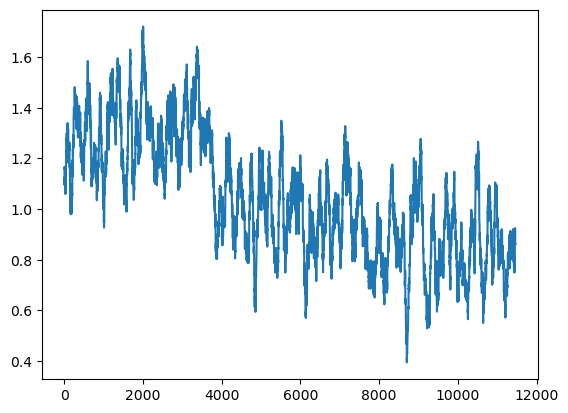

In [37]:
plt.plot(smooth(val_losses,100))

In [38]:
checkpoints = '/kaggle/working/EfficientNet/'
state = torch.load(checkpoints + 'checkpoint-3.pkl')
print(state['epoch'])

3


In [39]:
train_losses, val_losses = train(efficientnet, data['train'], data['val'], epochs=5, lr=0.001, print_every=10, state=state, checkpoint_path=checkpoints)

[3,    10] loss: 0.476
[3,    20] loss: 0.673
[3,    30] loss: 0.597
[3,    40] loss: 0.571
[3,    50] loss: 0.679
[3,    60] loss: 0.522
[3,    70] loss: 0.514
[3,    80] loss: 0.536
[3,    90] loss: 0.519
[3,   100] loss: 0.635
[3,   110] loss: 0.514
[3,   120] loss: 0.592
[3,   130] loss: 0.559
[3,   140] loss: 0.646
[3,   150] loss: 0.516
[3,   160] loss: 0.448
[3,   170] loss: 0.494
[3,   180] loss: 0.599
[3,   190] loss: 0.564
[3,   200] loss: 0.515
[3,   210] loss: 0.524
[3,   220] loss: 0.542
[3,   230] loss: 0.588
[3,   240] loss: 0.548
[3,   250] loss: 0.580
[3,   260] loss: 0.541
[3,   270] loss: 0.539
[3,   280] loss: 0.646
[3,   290] loss: 0.554
[3,   300] loss: 0.575
[3,   310] loss: 0.525
[3,   320] loss: 0.609
[3,   330] loss: 0.510
[3,   340] loss: 0.579
[3,   350] loss: 0.529
[3,   360] loss: 0.602
[3,   370] loss: 0.661
[3,   380] loss: 0.493
[3,   390] loss: 0.624
[3,   400] loss: 0.617
[3,   410] loss: 0.602
[3,   420] loss: 0.546
[3,   430] loss: 0.639
[3,   440] 

In [44]:
transform_test = transforms.Compose([
        transforms.Resize(384),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])

testset = torchvision.datasets.ImageFolder(root='../input/birds23wi/birds/test', transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)


In [46]:
print(len(testloader.dataset))

10000


In [47]:
predict(efficientnet, testloader, checkpoints + "preds.csv")

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
